# Tutorial 7: Simulating Qiskit Metal `design` objects with `palace` using `SQDMetal`

In this tutorial, we will cover how to do electrostatic and eigenmode simulations of a qubit-cavity system using `palace`.

**Requirements:**

- [ ] Ensure that [SQDMetal](https://github.com/sqdlab/SQDMetal) is installed in your environment.
- [ ] Ensure that [palace](https://github.com/awslabs/palace) is installed in your environment. Instructions [here](https://lfl-lab.github.io/SQuADDS/source/resources/palace.html).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()

os.makedirs('sims', exist_ok=True)

Define the path to the `palace` executable

In [4]:
path_to_palace = '/Users/shanto/LFL/palace/build/bin/palace'

## Electrostatic Simulation

We will be learning how to extract the capacitance matrix from an electrostatic simulation.

### For a qubit-claw system


Importing the relevant modules

In [5]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
import pandas as pd

We want to get the cap matrix for a system with TransmonCross, claw and ground (similar to the simulations we ran to build `SQuADDS_DB`)

In [6]:
from squadds import SQuADDS_DB, Analyzer

In [ ]:
# First, get a design from SQuADDS  
db = SQuADDS_DB()  
db.select_system("qubit")  
db.select_qubit("TransmonCross")  
df = db.create_system_df()
analyzer = Analyzer(db)  
  
# Define target parameters for your qubit  
target_params = {  
    "qubit_frequency_GHz": 4.2,  # Example value  
    "anharmonicity_MHz": -200    # Example value  
}  
  
# Find the closest design  
results = analyzer.find_closest(target_params, num_top=1)  
best_device = results.iloc[0]  
  
# Get the design options  
qubit_options = best_device["design_options"]  
  
  

06:30PM 33s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Populating font family aliases took 256 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 

06:30PM 33s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7faf675061c0; contentView=<QNSView: 0x7faf901effc0; QCocoaWindow(0x7faf901e75e0, window=QWidgetWindow(0x7faf650d1460, name="MainWindowPlotWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.

06:30PM 33s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7faf902cdd30; contentView=<QNSView: 0x7faf902cd590; QCocoaWindow(0x7faf902cd480, window=QWidgetWindow(0x7faf902ccf00, name="ElementsWindowWindow"))>> has active key-value observers (KVO)! These will stop work

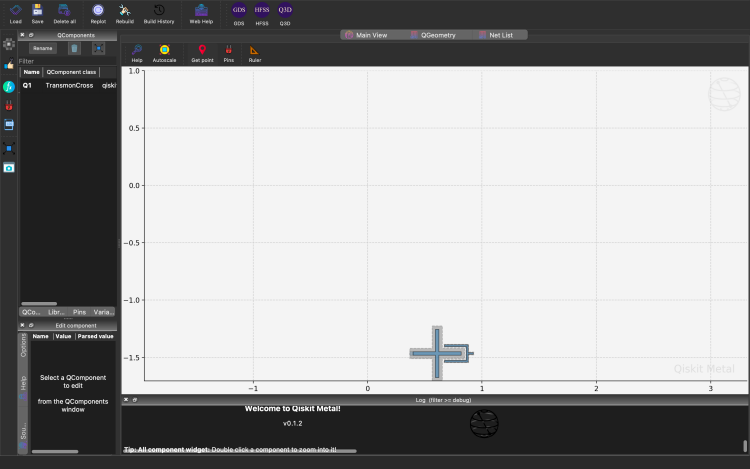

In [8]:
# Set up chip design as planar
design = designs.DesignPlanar({}, overwrite_enabled=True)


# Create GUI
gui = MetalGUI(design)

# Qubit and a claw
# Create the TransmonCross object with the modified options  
# Update only the position parameters  
qubit_options["pos_x"] = '0.6075mm'  
qubit_options["pos_y"] = '-1.464'  
Q1 = TransmonCross(design, 'Q1', options=qubit_options)

gui.rebuild()
design.rebuild()
gui.autoscale()
gui.screenshot('sims/qubit.png')
                                                

Call the `SQDMetal` objects. Change the hyper-parameters as needed for a more accurate simulation.

In [9]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation

user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solver_tol": 1.0e-8,                              #error residual tolerance for iterative solver
                "solver_maxits": 500,                              #number of solver iterations
                "mesh_max": 120e-6,                                #maxiumum element size for the mesh in mm
                "mesh_sampling": 150,                              #number of points to mesh along a geometry
                "fillet_resolution":12,                            #number of vertices per quarter turn on a filleted path
                "num_cpus": 10,                                      #number of CPU cores to use for simulation
                "palace_dir":path_to_palace
                }

In [10]:
#Creat the Palace Eigenmode simulation
cap_sim = PALACE_Capacitance_Simulation(name = 'transmon_cross_cap_sim',                                 #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True,
                                        )                                        #create mesh, config and HPC batch files

cap_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
cap_sim.add_ground_plane(threshold=1e-10)


To generate a fine mesh around our region of interest, we can use the `fine_mesh_in_rectangle` method by first getting the bounds of the region of interest.

In [11]:
bounds = design.components["Q1"].qgeometry_bounds()
bounds

array([ 0.3675, -1.704 ,  0.9277, -1.224 ])

In [12]:
#Fine-mesh the transmon cross qubit region
cap_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_sampling=100, mesh_min=10e-3, mesh_max=125e-3)

In [13]:
cap_sim.prepare_simulation()

You can check to see if all the metal components are correctly identified

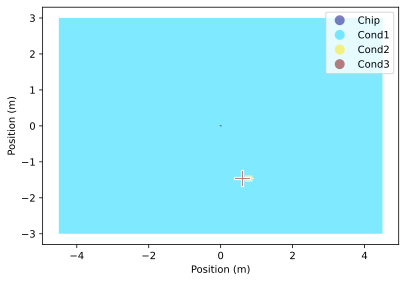

In [14]:
cap_sim.display_conductor_indices()

Similarly, you can verify the mesh is correct by visualizing the mesh

In [14]:
from SQDMetal.PALACE.Utilities.GMSH_Navigator import GMSH_Navigator

gmsh_nav = GMSH_Navigator(cap_sim.path_mesh)
gmsh_nav.open_GUI()

If all looks good, you can run the simulation

In [15]:
cap_matrix =cap_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/shanto/LFL/palace/build/bin/palace-arm64.bin xmon_cap_sim_GMSH.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/

Git changeset ID: v0.13.0-117-g748660c
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 369 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 7772 duplicate vertices for interior boundaries in the mesh
Added 16409 duplicate boundary elements for interior boundaries in the mesh
Added 4040 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 1.080e-02 m, t₀ = 3.602e-02 ns

Mesh curvature order: 1
Mesh bounding box:
 (Xmin, Ymin, Zmin) = (-5.400e-03, -3.600e-03, -7.500e

In [16]:
cdf = pd.DataFrame(cap_matrix)

# get rid of the first column
cdf = cdf.iloc[:, 1:]
 
# assigning the columns and indices based on our geometry
cdf.columns = ["ground", "claw", "cross"]
cdf.index = ["ground", "claw", "cross"]
cdf

,ground,claw,cross
ground,8.621504e-12,-2.458660e-13,-1.239444e-13
claw,-2.458660e-13,2.524815e-13,-4.830456e-15
cross,-1.239444e-13,-4.830456e-15,1.358696e-13


The above dataframe is the capacitance matrix for our system in Farads. 

To get a more accurate result - consider a higher order solver and a finer mesh.

---

## Eigenmodal Simulation

### For a qubit-cavity system

In [15]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict
from squadds.components.qubits import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import numpy as np
import matplotlib.pyplot as plt

For this example lets use an example geometry from [Tutorial 5](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-5_Designing_a_fab_ready_chip_with_SQuADDS.html#Making-the-Design) and build the design with `SQDMetal`

In [16]:
db.unselect_all()
db.select_system(["cavity_claw", "qubit"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")
df = db.create_system_df()

analyzer.reload_db()

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
target_params = {
                "qubit_frequency_GHz": 3.7,
                "resonator_type":"quarter",
                "anharmonicity_MHz": -210,
                "g_MHz": 100 # should provide a big punchout shift
                }

# computing the cavity frequency desired as per the design requirements
target_params["cavity_frequency_GHz"] = 2*(target_params["qubit_frequency_GHz"]+target_params["anharmonicity_MHz"]/1000)

results = analyzer.find_closest(target_params=target_params,num_top=1,metric="Euclidean")
results

Time taken to add the coupled H params: 4.370030879974365 seconds


,index_qc,PI_qubit,date_created_qubit,group_qubit,institution_qubit,uploader_qubit,renderer_options_qubit,setup_qubit,simulator_qubit,claw_to_claw,...,coupler_type,design_options_cavity_claw,design_tool_cavity_claw,resonator_type,design_options,EC,EJ,qubit_frequency_GHz,anharmonicity_MHz,g_MHz
12514,1900,"Eli Levenson-Falk, PhD",2023-09-20-142549,LFL,USC,Andre Kuo,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,102.50358,...,CLT,{'claw_opts': {'connection_pads': {'readout': ...,qiskit-metal,quarter,{'cavity_claw_options': {'coupler_type': 'CLT'...,0.180488,10.278024,3.66213,-205.109839,98.903433


In [18]:
data_qubit = analyzer.get_qubit_options(results)
data_cpw = analyzer.get_cpw_options(results)
data_coupler = analyzer.get_coupler_options(results)
LJs = analyzer.get_Ljs(results) # in nH

Creating a new `design` and `gui` object since we are running this in the same notebook. 

In [19]:
# First delete components 
design.delete_all_components()  
  
# Close the GUI  
gui.main_window.close()  
  
# Forced garbage collection  
gui = None  
design = None

In [20]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'


06:31PM 38s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7faf63991d30; contentView=<QNSView: 0x7faf63991690; QCocoaWindow(0x7faf63991580, window=QWidgetWindow(0x7faf6398e990, name="MainWindowPlotWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.

06:31PM 38s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: <QNSWindow: 0x7faf44069cb0; contentView=<QNSView: 0x7faf440698d0; QCocoaWindow(0x7faf440697c0, window=QWidgetWindow(0x7faf440692a0, name="ElementsWindowWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.

06:31PM 38s CRITICAL [_qt_message_handler]: line: 0, func: None(

Lets create the qubit with a junction and a claw

#### Qubit (with a junction) and Claw


In [21]:
from SQDMetal.Comps.Xmon import Xmon
from SQDMetal.Comps.Junctions import JunctionDolanPinStretch
from SQDMetal.Comps.Capacitors import CapacitorProngPin

In [22]:
# Calculate vBar_gap and hBar_gap
def extract_um(value: str) -> float:
    """Extract float from '30um'."""
    return float(value.replace('um', ''))

# Unpack parameters from data_qubit
cross_width = extract_um(data_qubit['cross_width'][0])  
cross_length = extract_um(data_qubit['cross_length'][0])  
cross_gap = extract_um(data_qubit['cross_gap'][0])  

# Now create the Xmon
xmon = Xmon(
    design,
    'xmon',
    options=Dict(
        pos_x = '0.375mm',
        pos_y = '-1.3',
        hBar_width = f"{cross_width}um",
        vBar_width = f"{cross_width}um",
        vBar_gap = f"{cross_gap}um",
        hBar_gap = f"{cross_gap}um",
        cross_width = f"{2*cross_length}um",
        cross_height = f"{2*cross_length}um",
        gap_up = data_qubit['cross_gap'][0],
        gap_left = data_qubit['cross_gap'][0],
        gap_right = data_qubit['cross_gap'][0],
        gap_down = data_qubit['cross_gap'][0]
    )
)

In [23]:
# Claw
prong_length = extract_um(data_qubit['claw_length'][0]) - extract_um(data_qubit['claw_width'][0])
pin_gap_side = extract_um(data_qubit['claw_gap'][0])+extract_um(data_qubit['cross_gap'][0])+extract_um(data_qubit['ground_spacing'][0])

claw = CapacitorProngPin(
    design,
    'claw',
    options=Dict(
        pin_inputs=Dict(start_pin=Dict(component='xmon', pin='up')),
        prong_width = data_qubit['claw_width'][0],
        pad_thickness = data_qubit['claw_width'][0],
        gap_front = data_qubit['cross_gap'][0],
        gap_back = data_qubit['claw_gap'][0],
        gap_side = data_qubit['claw_gap'][0],
        prong_length = f"{prong_length}um",
        pin_gap_side = f"{pin_gap_side}um"
    )
)


In [24]:
# Junction
junction = JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend=data_qubit['cross_gap'][0],
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))



#### Resonator and Feedline

Now lets add the resonator and feedline

In [25]:
# Lauchpad 1
x1 = '-2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um', trace_width = data_cpw["trace_width"], trace_gap = data_cpw["trace_gap"])
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um', trace_width = data_cpw["trace_width"], trace_gap = data_cpw["trace_gap"])
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width = data_cpw["trace_width"],
                                            trace_gap = data_cpw["trace_gap"],
                                            fillet='90um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


In [26]:
#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180))


# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = data_cpw["trace_width"] 
design.variables['cpw_gap'] = data_cpw["trace_gap"] 

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = False,
        fillet='99.9 um',
        lead = dict(start_straight='300um'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'claw', pin= 'a')), ))

Check the design

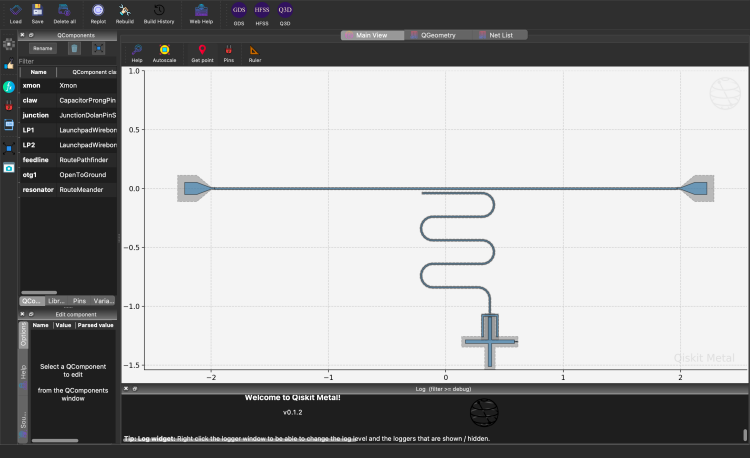

In [27]:
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
gui.screenshot('sims/qubit-cavity.png')

Define the hyper-parameters for the eigenmode simulation

In [28]:
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 2e9,                              #starting frequency in Hz 
                 "number_of_freqs": 6,                              #number of eigenmodes to find
                 "solns_to_save": 6,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 1.0e-3,                              #error residual tolerance foriterative solver
                 "solver_maxits": 3,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 10,                                      #number of CPU cores to use for simulation
                 "palace_dir":path_to_palace
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='qubit-cavity-eig-test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files


Assigning the materials to the interfaces, add ports to the design, and add some mesh.

In [29]:
from SQDMetal.Utilities.Materials import MaterialInterface

eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
eigen_sim.fine_mesh_in_rectangle(0.2875e-3, -1.2e-3, 0.63e-3, -1.72e-3, min_size=15e-6, max_size=120e-6)

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6)
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6)
eigen_sim.create_port_JosephsonJunction('junction', L_J=LJs[0]*1e-9, C_J=10e-15) # Guessing the C_J value really

# #Fine-mesh routed paths
eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=25e-6, max_size=250e-6)
eigen_sim.fine_mesh_around_comp_boundaries(['xmon'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))

junction_index 0
comp_id 3
gsdf   component    name                             geometry  layer  subtract  \
0         3  design  LINESTRING (0.585 -1.3, 0.615 -1.3)      2     False   

   helper  chip   width hfss_inductance  hfss_capacitance  hfss_resistance  \
0   False  main  0.0054            10nH                 0                0   

   hfss_mesh_kw_jj q3d_inductance  q3d_capacitance  q3d_resistance  \
0         0.000007           10nH                0               0   

   q3d_mesh_kw_jj      gds_cell_name  
0        0.000007  my_other_junction  
gsdf   component    name                             geometry  layer  subtract  \
0         3  design  LINESTRING (0.585 -1.3, 0.615 -1.3)      2     False   

   helper  chip   width hfss_inductance  hfss_capacitance  hfss_resistance  \
0   False  main  0.0054            10nH                 0                0   

   hfss_mesh_kw_jj q3d_inductance  q3d_capacitance  q3d_resistance  \
0         0.000007           10nH                0

In [30]:
eigen_sim.prepare_simulation()

Directory 'qubit-cavity-eig-test' created


Checking the meshfile

In [ ]:
gmsh_nav = GMSH_Navigator(eigen_sim.path_mesh)
gmsh_nav.open_GUI()

If all looks good, lets run the simulation

**NOTE:** If you are using a `palace` build that is from 2025, you will need to remove the `Excitation` key from the `LumpedPort` boundary condition in the `sim_config.json` file so please execute the following cell.

If you are using a `palace` build that is from 2024 or older, **you should skip this cell.**

In [ ]:
import json

with open(eigen_sim._sim_config, 'r') as file:
    sim_config_dict = json.load(file)

del sim_config_dict["Boundaries"]["LumpedPort"][0]["Excitation"]

with open(eigen_sim._sim_config, 'w') as file:
    json.dump(sim_config_dict, file, indent=4)

In [31]:
eigen_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/shanto/LFL/palace/build/bin/palace-arm64.bin qubit-cavity-eig-test.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/

Git changeset ID: v0.13.0-117-g748660c
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 2574 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 5333 duplicate vertices for interior boundaries in the mesh
Added 12701 duplicate boundary elements for interior boundaries in the mesh
Added 1550 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 5.520e-03 m, t₀ = 1.841e-02 ns

Mesh curvature order: 1
Mesh bounding box:
 (Xmin, Ymin, Zmin) = (-2.760e-03, -2.440e-03, -2

Reading the eigenmode data now

In [33]:
def read_csv_to_dataframe(file_path):
    return pd.read_csv(file_path)

eigen_df = read_csv_to_dataframe(os.path.join(eigen_sim._output_data_dir, 'eig.csv'))
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df

,m,Re{f} (GHz),Im{f} (GHz),Q,Error (Bkwd.),Error (Abs.),kappa (kHz)
0,1.0,3.136773,0.000142,11052.078980,7.453931e-09,0.001332,283.817505
1,2.0,7.182393,0.053806,66.745561,1.006761e-06,0.179951,107608.543661
2,3.0,7.984743,0.060560,65.926448,1.045469e-06,0.186871,121115.923577
3,4.0,9.637757,0.048533,99.291263,1.024503e-06,0.183126,97065.505810
4,5.0,9.940094,0.079460,62.549670,1.765757e-06,0.315623,158915.201768
5,6.0,10.696626,0.247229,21.638798,8.803651e-07,0.157363,494326.244903


From our requirements, we wanted a qubit frequency of 3.7 GHz and a cavity frequency of

In [36]:
target_params["cavity_frequency_GHz"]

6.98

From the simulations, it seems like mode 1 is the qubit mode (found to be 3.136 GHz) and mode 2 is the cavity mode (found to be 7.183 GHz) given their frequencies

Lets' visualize all the eigenmodes in `paraview` to see if thats the case. Here are some screenshots from this toy example.

<table>
    <tr>
        <td><img src="qubit-mode1.png" width="50%" alt="Mode 2"></td>
        <td><img src="cavity-mode2.png" width="50%" alt="Mode 4"></td>
        <td><img src="cavity-mode3.png" width="50%" alt="Mode 4"></td>
    </tr>
    <tr>
        <td>Mode 1: Qubit Mode</td>
        <td>Mode 2: Cavity Mode?</td>
        <td>Mode 3: Cavity Mode?</td>
    </tr>
</table>

It seems like that indeed mode 1 is the qubit mode and mode 3 looks to be like the cavity mode (apologies for the bad quality of the images).

**Of course, this simulation was done with really coarse hyperparameters (ran in 1.5 minutes on my 2021 Macbook Pro) so this results are somewhat promising!**


## EPR Calculations

Since `palace` does automatic postprocessing of energy-participation ratios (EPRs) for circuit quantization and interface or bulk participation ratios for predicting dielectric loss, we can use this to do some quantum analysis from the eigenmode simulation when lumped inductive elements (i.e. josephson junctions) exist in the simulated geometry.

First, we need to retrieve the mode-port EPRs from the eigenmode simulation.

In [37]:
mode_dict = eigen_sim.retrieve_mode_port_EPR_from_file(eigen_sim._output_data_dir)

#get particpation ratios and frequencies from the simulation
participation_ratios = mode_dict['mat_mode_port']
frequencies = mode_dict['eigenfrequencies']

We have identified the qubit and cavity modes from the eigenmode simulation as mode 3 and mode 4 respectively.

In [49]:
qubit_idx = 0
cavity_idx = 2

In [50]:
linear_qubit_freq = eigen_df['Re{f} (GHz)'][qubit_idx]*1e9
linear_res_freq = eigen_df['Re{f} (GHz)'][cavity_idx]*1e9
P_qubit = abs(participation_ratios[qubit_idx, 0])
P_cav = abs(participation_ratios[cavity_idx, 0])

In [51]:
P_qubit, P_cav

(0.9902988796, 5.020978473e-05)

Now, let's calculate the qubit and cavity Hamiltonian parameters using these participation ratios.

In [52]:
#Constants used for calculations
from scipy.constants import Planck, e, hbar
phi0 = hbar/(2*e)

#Josephson Energy (Ej) and linear inductance (Lj)
delta_super = (1.8e-4 / 2) * e
Lj = LJs[0]*1e-9
Ej = phi0**2 / Lj

#Normalize Participation Ratios
P_qubit_normalised = P_qubit / (P_qubit + P_cav)
P_cav_normalised = P_cav / (P_qubit + P_cav)

#Enter in Frequencies from Simulation
omega_qubit = 2 * np.pi * linear_qubit_freq
omega_res = 2 * np.pi * linear_res_freq

#phi zero-point fluctuations for qubit
phi_zpf_sq = P_qubit * hbar * 2 * omega_qubit  / (2*Ej)

#anharmonicity qubit (self kerr)
anharm_qubit = P_qubit**2 * hbar * omega_qubit**2 / (8*Ej)

#anharmonicity resonator (self kerr)
anharm_res = P_cav**2 * hbar * omega_res**2 / (8*Ej)

#Charging Energy (Ec)
Ec = anharm_qubit * hbar

#Total Capacitance
C_total = e**2 / (2*Ec)

#cross kerr - dispersive shit (chi)
cross_kerr = (P_qubit * P_cav * hbar * omega_qubit * omega_res) / (4*Ej)

#lamb-shift of qubit frequency
lamb_shift_qubit = anharm_qubit - cross_kerr/2

#lamb-shift of res frequency
lamb_shift_res = anharm_res - cross_kerr/2

#detuning, delta
delta = ((linear_res_freq - anharm_res/(2*np.pi)) - (linear_qubit_freq - anharm_qubit/(2*np.pi)))

#resonator-qubit coupling strength (g)
disp_shift_qubit = cross_kerr
g_rwa = np.sqrt(disp_shift_qubit * delta  * (1 + delta/anharm_qubit))

# coupling strength (g) from SQuADDS Paper
Delta = omega_res - omega_qubit      # rad/s
Sigma = omega_res + omega_qubit      # rad/s
alpha = -anharm_qubit                # rad/s (already angular)
chi = -disp_shift_qubit              # rad/s (already angular)
# Denominator (s/rad)
denom = (alpha / (Delta * (Delta - alpha))) - (alpha / (Sigma * (Sigma + alpha)))

# Convert to linear frequency in MHz (optional, for reporting)
g_rad = np.sqrt(chi / (2 * denom))     # rad/s
g_MHz = g_rad / (2 * np.pi * 1e6)    # MHz

Interesting to check what `scqubits` says about the Hamiltonian parameters computed using the simulation results.

In [53]:
import scqubits as scq
from scqubits.core.transmon import Transmon

scq.set_units("GHz")

# Using scqubits to find the Josephson energy and charging energy using the qubit frequency and anharmonicity from EPR
qubit_freq_GHz = linear_qubit_freq/1e9 - lamb_shift_qubit/(2*np.pi*1e9)
qubit_anharm_GHz = (alpha*1e-9)/(2*np.pi)
EJ_scq, EC_scq = Transmon.find_EJ_EC(qubit_freq_GHz, qubit_anharm_GHz)


# Using scqubits to find the qubit frequency and anharmonicity now using the Josephson energy and charging energy from EP
EJ_GHz = Ej / (hbar * 2 * np.pi *  1e9)
EC_GHz = anharm_qubit  / (2*np.pi*1e9)
transmon = Transmon(EJ=EJ_GHz, EC=EC_GHz, ng=0, ncut=30)
qubit_freq_scq= transmon.E01()
anharm_qubit_scq = transmon.anharmonicity() * 1E3  # MHz

# Using scqubits to find the C_qubit capacitance

def C_qubit_from_Ec(Ec):
    """
    Calculate the capacitance (C_qubit) in fF from the charging energy (Ec) in GHz.
    """
    Ec_Joules = Ec * 1e9 * Planck
    Cs_SI = (e ** 2) / (2 * Ec_Joules)
    Cs_fF = Cs_SI * 1e15
    return Cs_fF

C_qubit_scq = C_qubit_from_Ec(EC_scq)

 /opt/homebrew/Caskroom/mambaforge/base/envs/squadds_staging_env/lib/python3.10/site-packages/scqubits/core/units.py: 65


In [58]:
hamiltonian_params = [
    ("Ej", Ej / (hbar * 2 * np.pi *  1e9), "GHz"),
    ("Ej (scqubits)", EJ_scq, "GHz"),
    ("Ec", anharm_qubit  / (2*np.pi*1e9), "GHz"),
    ("Ec (scqubits)", EC_scq, "GHz"),
    ("Ej/Ec", Ej/Ec, "unitless"),
    ("Ej/Ec (scqubits)", EJ_scq/EC_scq, "unitless"),
    ("Lj", Lj/1e-9, "nH"),
    ("C_qubit", C_total/1e-15, "fF"),
    ("C_qubit (scqubits)", C_qubit_scq, "fF"),
    ("C_qubit (from SQuADDS DB)", results["cross_to_claw"].values[0]+results["cross_to_ground"].values[0], "fF"),
    ("Participation Ratio Qubit", P_qubit, "unitless"),
    ("Participation Ratio Qubit (Normalized)", P_qubit_normalised, "unitless"),
    ("Participation Ratio Cavity", P_cav, "unitless"),
    ("Participation Ratio Cavity (Normalized)", P_cav_normalised, "unitless"),
    ("Linear Qubit Frequency", linear_qubit_freq/1e9, "GHz"),
    ("Qubit Frequency", linear_qubit_freq/1e9 - lamb_shift_qubit/(2*np.pi*1e9), "GHz"),
    ("Qubit Frequency (scqubits)", qubit_freq_scq, "GHz"),
    ("Qubit Frequency (from SQuADDS DB)", results["qubit_frequency_GHz"].values[0], "GHz"),
    ("Qubit Anharmonicity", anharm_qubit / (2*np.pi*1e6), "MHz"),
    ("Qubit Anharmonicity (scqubits)", -anharm_qubit_scq, "MHz"),
    ("Qubit Anharmonicity (from SQuADDS DB)", - results["anharmonicity_MHz"].values[0], "MHz"),
    ("Linear Cavity Frequency", linear_res_freq/1e9, "GHz"),
    ("Cavity Frequency", linear_res_freq/1e9 - lamb_shift_res/(2*np.pi*1e9), "GHz"),
    ("Cavity Anharmonicity", anharm_res / (2*np.pi*1e6), "MHz"),
    ("Dispersive Shift (chi)", cross_kerr/ (2*np.pi*1e6), "MHz"),
    ("Cavity-Qubit Coupling [Ref. SQuADDS], g", g_MHz, "MHz"),
    ("Cavity-Qubit Coupling [RWA], g", g_rwa/(2*np.pi*1e6), "MHz"),
    ("Detuning", delta/1e9, "GHz"),
    ("Flux_ZPF_squared", phi_zpf_sq, "unitless"),
]

# Create DataFrame
hamiltonian_df = pd.DataFrame(hamiltonian_params, columns=["Parameter", "Value", "Unit"])

# Function to format values
def format_float_six_decimal(val, idx):
    return f"{val:.6f}"

# Apply formatting
hamiltonian_df['Value'] = [
    format_float_six_decimal(val, idx) for idx, val in enumerate(hamiltonian_df['Value'])
]

print(hamiltonian_df.to_string(index=False))

                              Parameter      Value     Unit
                                     Ej  10.278024      GHz
                          Ej (scqubits)  11.403408      GHz
                                     Ec   0.117354      GHz
                          Ec (scqubits)   0.107456      GHz
                                  Ej/Ec  87.581095 unitless
                       Ej/Ec (scqubits) 106.121806 unitless
                                     Lj  15.903982       nH
                                C_qubit 165.057588       fF
                     C_qubit (scqubits) 180.262233       fF
              C_qubit (from SQuADDS DB) 107.321280       fF
              Participation Ratio Qubit   0.990299 unitless
 Participation Ratio Qubit (Normalized)   0.999949 unitless
             Participation Ratio Cavity   0.000050 unitless
Participation Ratio Cavity (Normalized)   0.000051 unitless
                 Linear Qubit Frequency   3.136773      GHz
                        Qubit Frequency 

## Work In Progress ⏳

We are studying the hyper-parameters needed to converge our simulations to that of Ansys/experimentally verified results with `palace`. Once that is done, we will update this tutorial with a more comprehensive guide and native API

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>This tutorial is written by Sadman Ahmed Shanto</p> 
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2025.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>